In [1]:
import glob
import stella
import numpy as np
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['font.size'] = 20

2024-08-06 13:28:21.447739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds = stella.FlareDataSet(fn_dir='lc_inject',
                         cadences=200,
                         validation=1.,
                         catalog='lc_inject/inject_catalog.csv')

Reading in training set files.


100%|██████████| 10188/10188 [00:03<00:00, 3245.32it/s]


5138 positive classes (flare)
7777 negative classes (no flare)
66.0% class imbalance


In [3]:
ds_neg = copy.deepcopy(ds)
ds_neg.train_data = np.fliplr(ds_neg.train_data)
ds_neg.val_data = np.fliplr(ds_neg.val_data)
ds_neg.test_data = np.fliplr(ds_neg.test_data)
ds_neg.train_labels = np.zeros(len(ds_neg.train_labels))
ds_neg.val_labels = np.zeros(len(ds_neg.val_labels))
ds_neg.test_labels = np.zeros(len(ds_neg.test_labels))

In [4]:
ds.train_data = np.vstack((ds.train_data, ds_neg.train_data))
ds.val_data = np.vstack((ds.val_data, ds_neg.val_data))
ds.test_data = np.vstack((ds.test_data, ds_neg.test_data))

ds.train_labels = np.append(ds.train_labels, ds_neg.train_labels)
ds.val_labels = np.append(ds.val_labels, ds_neg.val_labels)
ds.test_labels = np.append(ds.test_labels, ds_neg.test_labels)

ds.val_ids = np.append(ds.val_ids, ds_neg.val_ids)
ds.val_tpeaks = np.append(ds.val_tpeaks, ds_neg.val_tpeaks)
ds.test_ids = np.append(ds.test_ids, ds_neg.test_ids)
ds.test_tpeaks = np.append(ds.test_tpeaks, ds_neg.test_tpeaks)

In [5]:
# ds = stella.FlareDataSet(fn_dir='comets10k',
#                          cadences=150,
#                          time_offset=0,
#                          catalog='comets10k/comets10k.txt')

In [6]:
ds.train_data.shape, ds.test_data.shape, ds.val_data.shape

((20664, 200, 1), (0, 200, 1), (5166, 200, 1))

Text(0.5, 0, 'Cadences')

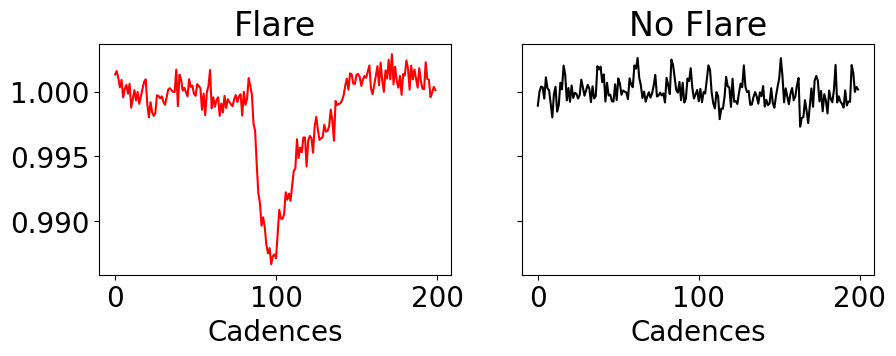

In [7]:
n = 1
ind_pc = np.where(ds.train_labels==1)[0] # Flares
ind_nc = np.where(ds.train_labels==0)[0] # No flares

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,3),
                               sharex=True, sharey=True)
ax1.plot(ds.train_data[ind_pc[n]], 'r')
ax1.set_title('Flare')
ax1.set_xlabel('Cadences')
ax2.plot(ds.train_data[ind_nc[n]], 'k')
ax2.set_title('No Flare')
ax2.set_xlabel('Cadences')

In [8]:
OUT_DIR = './models'

In [9]:
cnn = stella.ConvNN(output_dir=OUT_DIR,
                    ds=ds)

In [10]:
ep = 50
cnn.train_models(seeds=2, epochs=ep, shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 200, 16)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 16)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           3136      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 50, 64)            0

2024-08-06 13:28:36.809007: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
323/323 [==============================] - 3s 7ms/step - loss: 0.5057 - accuracy: 0.8015 - precision: 0.2000 - recall: 2.4402e-04 - val_loss: 0.5142 - val_accuracy: 0.7987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
323/323 [==============================] - 2s 6ms/step - loss: 0.5007 - accuracy: 0.8017 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5028 - val_accuracy: 0.7987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
323/323 [==============================] - 2s 6ms/step - loss: 0.5013 - accuracy: 0.8017 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5030 - val_accuracy: 0.7987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
323/323 [==============================] - 2s 6ms/step - loss: 0.5001 - accuracy: 0.8017 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5021 - val_accuracy: 0.7987 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
323/323 [========================

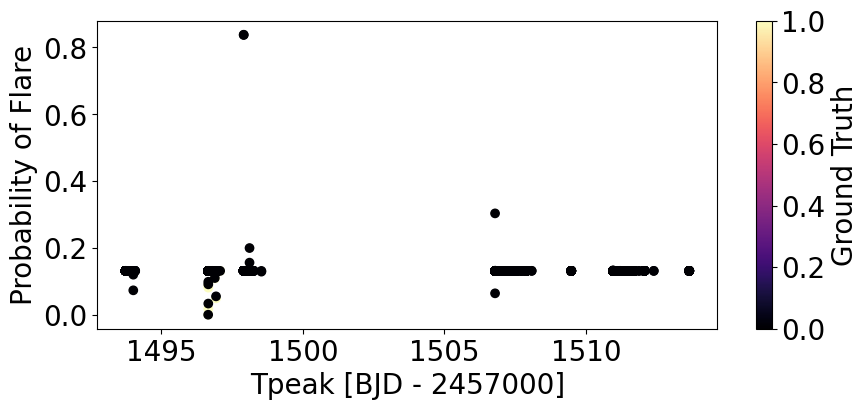

In [11]:
plt.figure(figsize=(10,4))
plt.scatter(cnn.val_pred_table['tpeak'], cnn.val_pred_table['pred_s0002'],
            c=cnn.val_pred_table['gt'], vmin=0, vmax=1, cmap='magma')
plt.xlabel('Tpeak [BJD - 2457000]')
plt.ylabel('Probability of Flare')
plt.colorbar(label='Ground Truth')

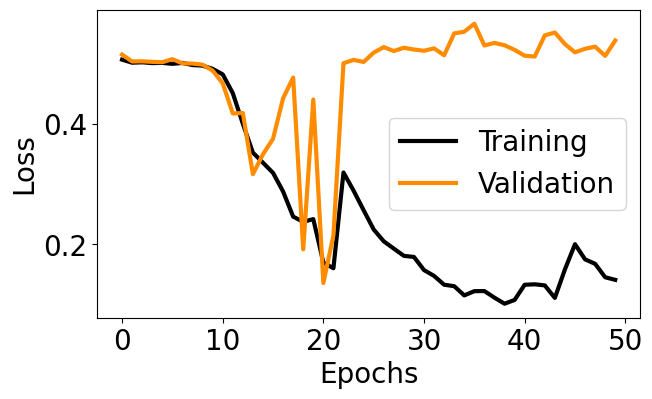

In [12]:
plt.figure(figsize=(7,4))
plt.plot(cnn.history_table['loss_s0002'], 'k', label='Training', lw=3)
plt.plot(cnn.history_table['val_loss_s0002'], 'darkorange', label='Validation', lw=3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

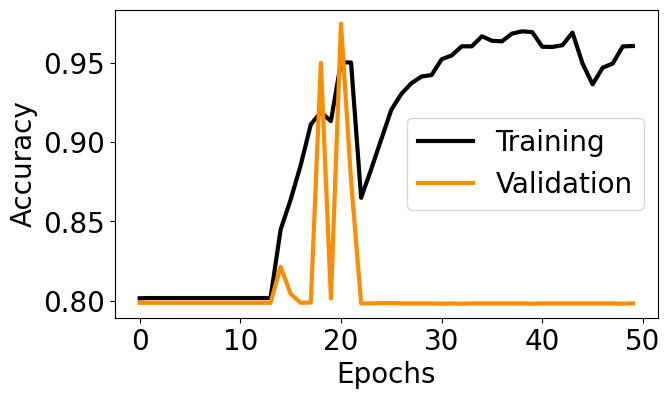

In [13]:
plt.figure(figsize=(7,4))
plt.plot(cnn.history_table['accuracy_s0002'], 'k', label='Training', lw=3)
plt.plot(cnn.history_table['val_accuracy_s0002'], 'darkorange', label='Validation', lw=3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

33/33 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 0s 1ms/step


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


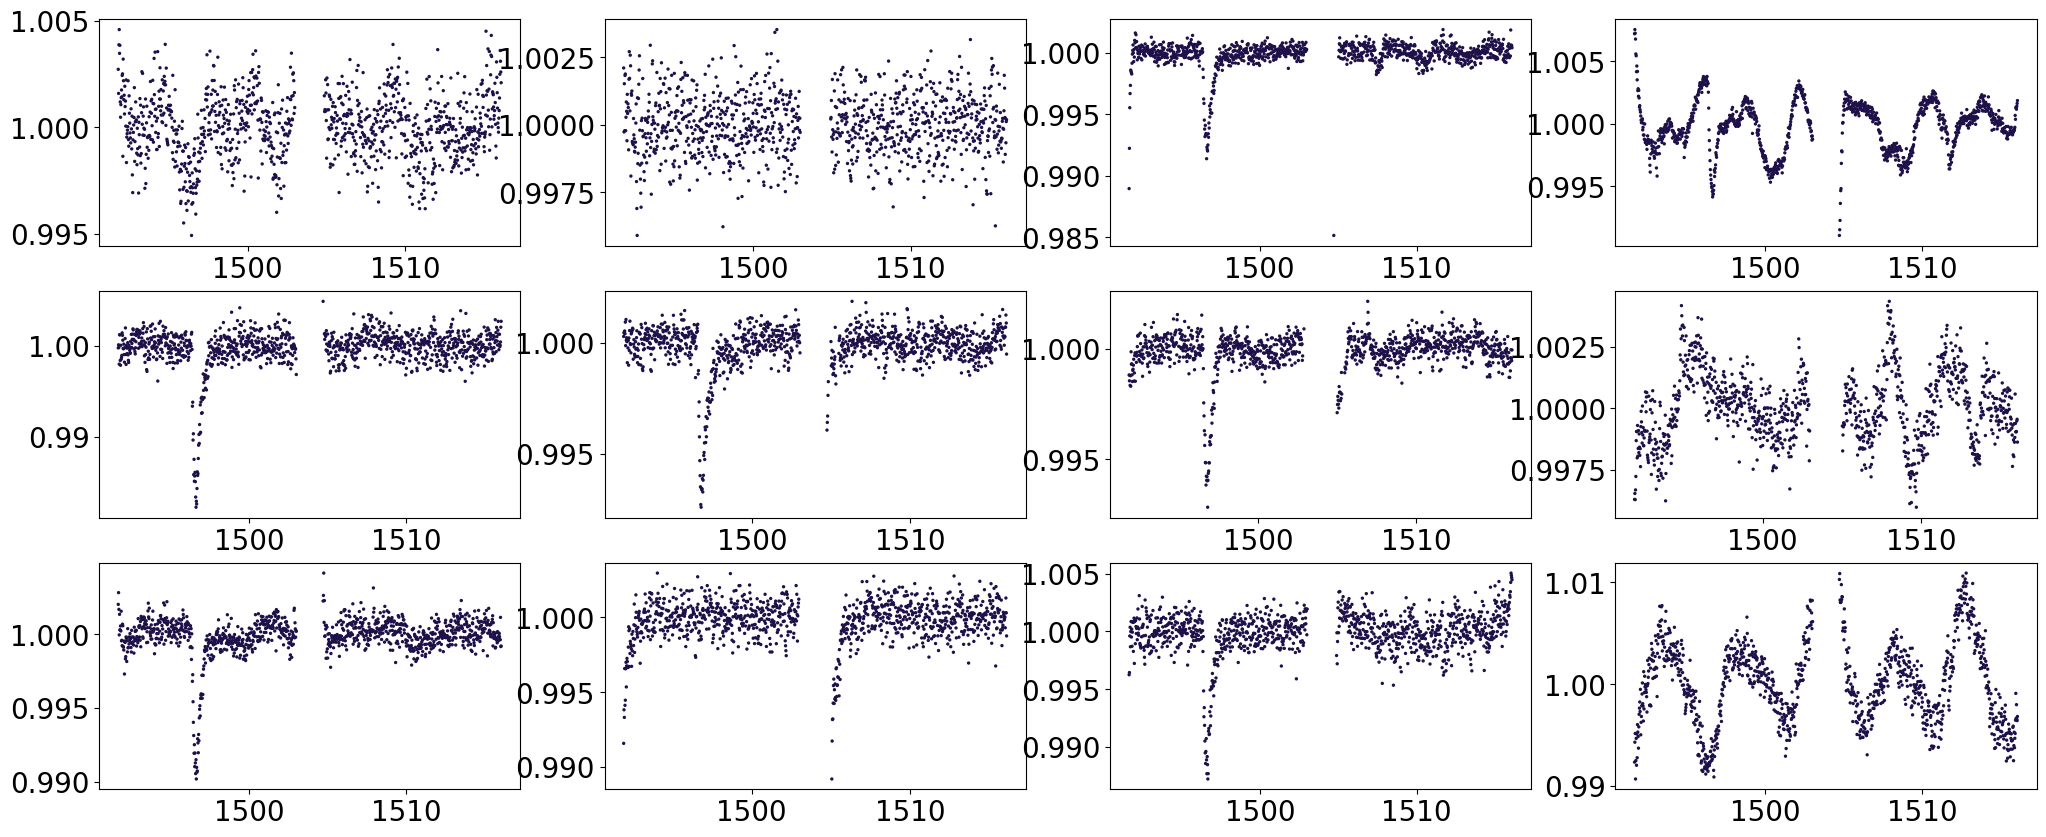

In [14]:
# fs = glob.glob('comets10k/*npy')
fs = glob.glob('lc_inject/*npy')

fig, ax = plt.subplots(3, 4, figsize=(25, 10))

for i, a in enumerate(ax.flatten()):
    d = np.load(fs[i])
    cnn.predict(modelname=f'models/ensemble_s0002_i{ep:04g}_b0.73.h5',
                times=d[0],
                fluxes=d[1],
                errs=d[2])
    a.scatter(cnn.predict_time[0], cnn.predict_flux[0],
              c=cnn.predictions[0], s=2, vmin=0, vmax=1, cmap='magma')
    # a.scatter(cnn.predict_time[0], cnn.predictions[0]+1, s=2)

  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

33/33 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 0s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

34/34 [==============================] - 0s 1ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

35/35 [==============================] - 0s 1ms/step


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


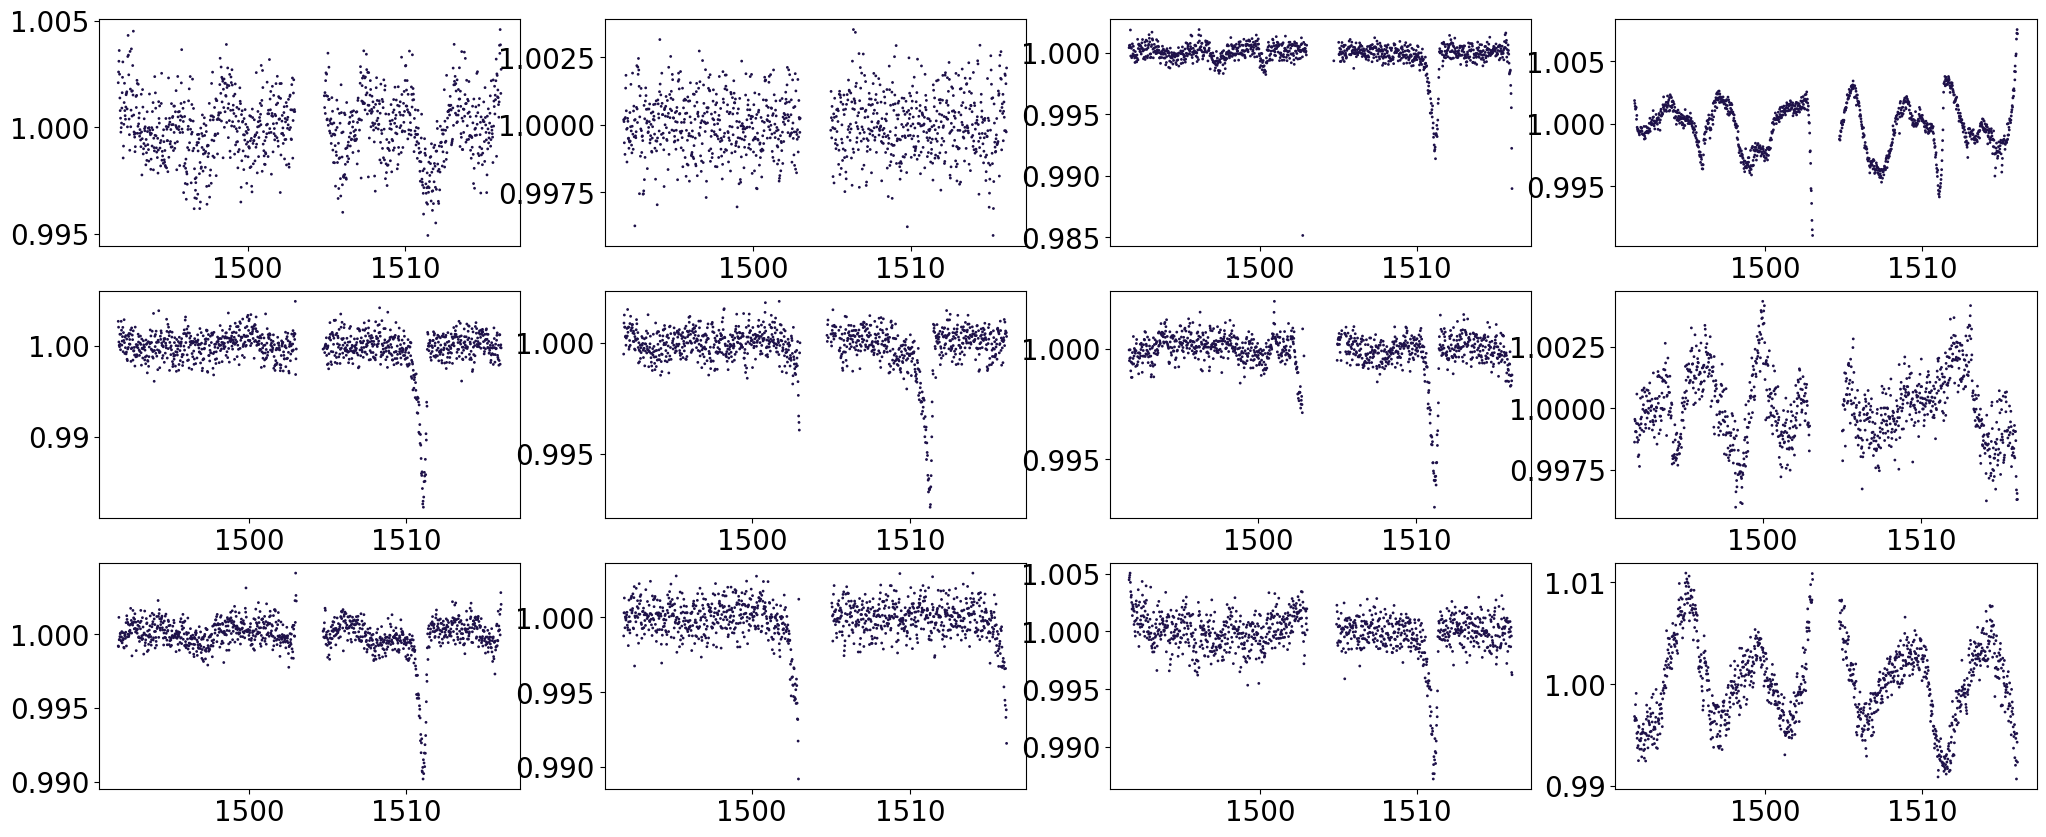

In [15]:
# fs = glob.glob('comets10k/*npy')
fs = glob.glob('lc_inject/*npy')

fig, ax = plt.subplots(3, 4, figsize=(25, 10))

for i, a in enumerate(ax.flatten()):
    d = np.load(fs[i])
    cnn.predict(modelname=f'models/ensemble_s0002_i{ep:04g}_b0.73.h5',
                times=d[0],
                fluxes=np.flipud(d[1]),
                errs=d[2])
    a.scatter(cnn.predict_time[0], cnn.predict_flux[0],
              c=cnn.predictions[0], s=1, vmin=0, vmax=1, cmap='magma')
    # a.scatter(cnn.predict_time[0], cnn.predictions[0], s=2)

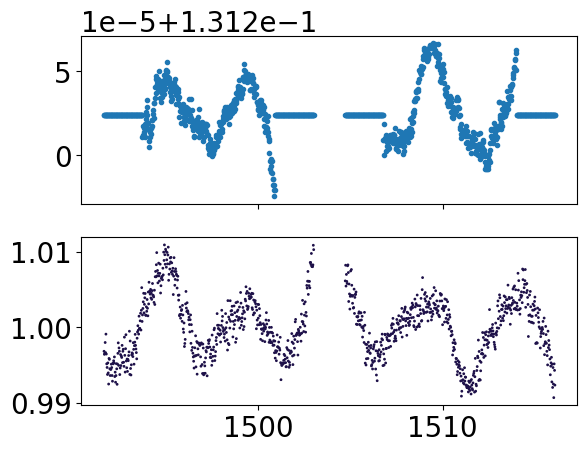

In [16]:
fig, ax = plt.subplots(2, sharex=True)
ax[0].plot(cnn.predict_time[0], cnn.predictions[0], '.')
ax[1].scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], s=1, vmin=0, vmax=1, cmap='magma')